# CIFAR10 Classifier

This notebook prepares an CIFAR10 classifier using a Convolutional Neural Network (CNN)

In [1]:
# import required libs
import keras
import numpy as np
from keras import backend as K
from keras.datasets import cifar10
from keras.models import Sequential
from keras import regularizers, optimizers
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization

import cnn_utils as utils

import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
np.random.seed(42)

%matplotlib inline

Using TensorFlow backend.


Set Parameters

In [2]:
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 25
INPUT_SHAPE = (32, 32, 3)
WEIGHT_DECAY = 1e-4
KFOLD_WEIGHT_PATH=r'../model/cnn_cifar10_weights_{epoch:02d}_{val_acc:.2f}.hdf5'

In [3]:
label_dict = {0:'airplane',
             1:'automobile',
             2:'bird',
             3:'cat',
             4:'deer',
             5:'dog',
             6:'frog',
             7:'horse',
             8:'ship',
             9:'truck'}

# for evaluation
TOP_N = 1

## Get CIFAR10 Dataset

The CIFAR10 dataset is available through keras load_data() API. It returns train and test datasets along with their corresponding target labels.

We download the dataset and perform a quick scaling by multiplying with a scalar quantity of 1/255.

In [4]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [14]:
x_train = x_train/255.
x_test = x_test/255.

## Dataset Details

The dataset consists of 10 different classes having a total of 60,000 samples with 50k in training and the rest in test dataset

In [5]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

## Build a CNN based deep neural network

Using ```keras``` we prepare a simple CNN by stacking Convolutional, Maxpooling, BatchNormalization, Flatten and Dense Layers. We utilize Dopouts to keep the model from overfitting

In [7]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=INPUT_SHAPE))

model.add(Conv2D(32, (3,3), padding='same', 
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

## Visualize the network architecture

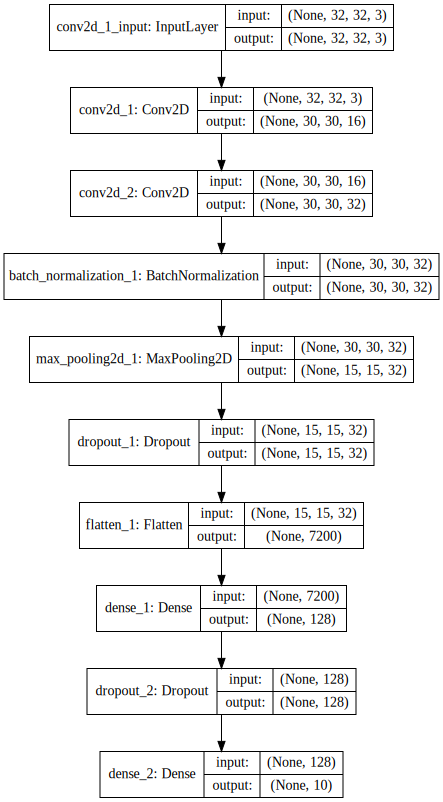

In [8]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, 
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               921728    
__________

## Compile the model

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [16]:
early_stop_callback = [EarlyStopping(monitor='val_loss', 
                                     patience=3, verbose=0),
                       ModelCheckpoint(KFOLD_WEIGHT_PATH, 
                                       monitor='val_loss', 
                                       save_best_only=True, 
                                       verbose=0),
                      ]

## Train the classifier

In [17]:
history = model.fit(x_train, y_train,
                    validation_split=0.1,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=early_stop_callback,)

Train on 45000 samples, validate on 5000 samples
Epoch 1/25
45000/45000 [==============================] - 293s - loss: 1.5285 - acc: 0.4553 - val_loss: 2.8227 - val_acc: 0.1058
Epoch 2/25
45000/45000 [==============================] - 256s - loss: 1.3115 - acc: 0.5370 - val_loss: 1.8764 - val_acc: 0.3810
Epoch 3/25
45000/45000 [==============================] - 375s - loss: 1.1782 - acc: 0.5836 - val_loss: 1.2101 - val_acc: 0.6220
Epoch 4/25
45000/45000 [==============================] - 248s - loss: 1.0834 - acc: 0.6194 - val_loss: 0.9893 - val_acc: 0.6560
Epoch 5/25
45000/45000 [==============================] - 206s - loss: 1.0069 - acc: 0.6427 - val_loss: 0.9871 - val_acc: 0.6506
Epoch 6/25
45000/45000 [==============================] - 205s - loss: 0.9369 - acc: 0.6703 - val_loss: 0.9481 - val_acc: 0.6718
Epoch 7/25
45000/45000 [==============================] - 207s - loss: 0.8840 - acc: 0.6876 - val_loss: 0.9160 - val_acc: 0.6900
Epoch 8/25
45000/45000 [========================

In [ ]:
#model.save(filepath=r'../model/cnn_cifar10.h5')

## Predict and test model performance

In [18]:
score = model.evaluate(x_test, y_test, verbose=1)

 9984/10000 [============================>.] - ETA: 0s

In [19]:
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.01026107655
Test accuracy: 0.6758


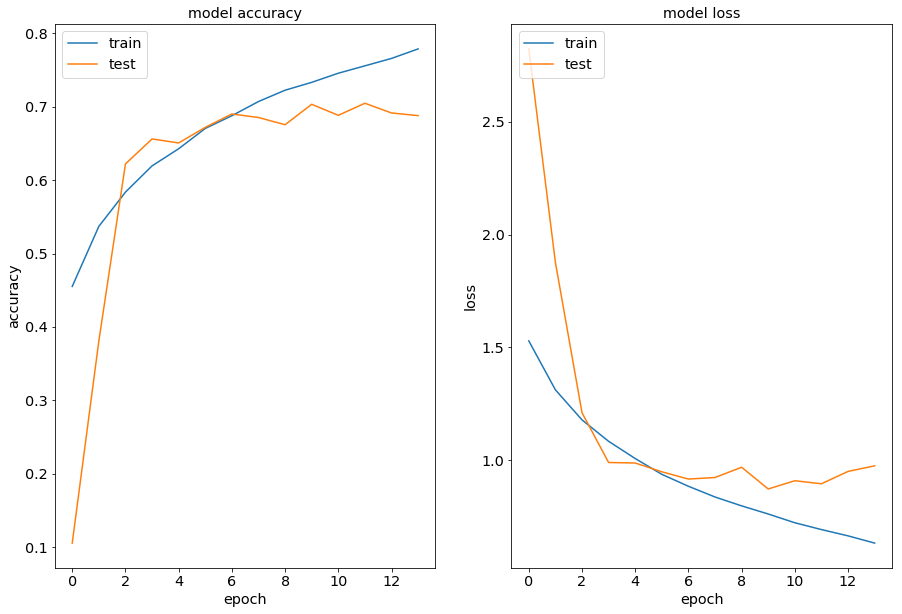

In [20]:
plt.figure(1,figsize=(15,10))  

# summarize history for accuracy  

plt.subplot(121)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(122)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

Though the model performance is commendable, there are signs of overfitting. 
The test loss starts increasing after a few epochs along with flattening of the test accuracy

# How CNN Classifies an Image? 

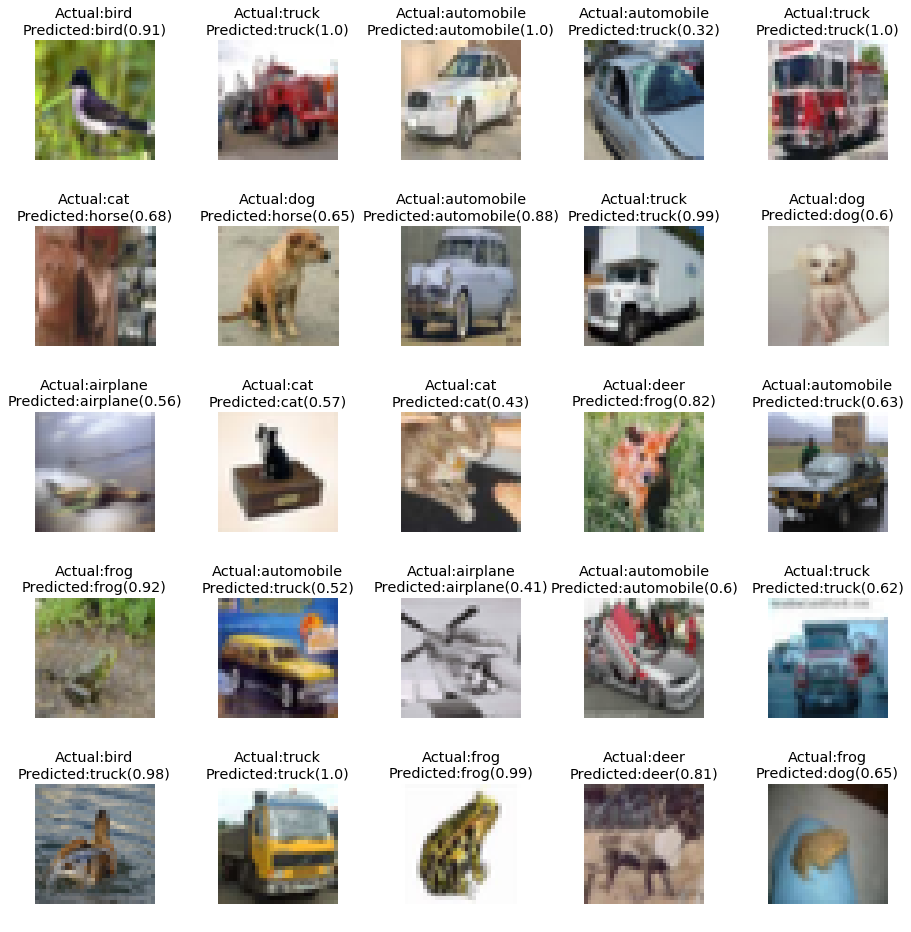

In [27]:
utils.plot_predictions(model=model,dataset=x_test,
                       dataset_labels=y_test,
                       label_dict=label_dict,
                       batch_size=25,
                       grid_height=5,
                       grid_width=5)

## Utility Methods to understand CNN
+ source: https://github.com/fchollet/keras/issues/431
+ source: https://github.com/philipperemy/keras-visualize-activations/blob/master/read_activations.py

In [22]:
test_image_idx = 1005

In [23]:
activations = utils.get_activations(model, x_test[test_image_idx].reshape(1,32,32,3))

----- activations -----
(1, 30, 30, 16)
(1, 30, 30, 32)
(1, 30, 30, 32)
(1, 15, 15, 32)
(1, 15, 15, 32)
(1, 7200)
(1, 128)
(1, 128)
(1, 10)


Displaying activation map 0


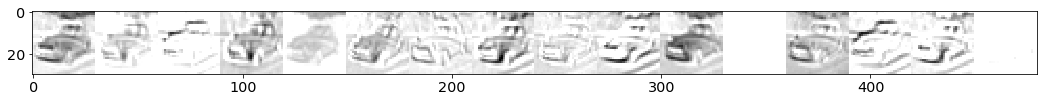

Displaying activation map 1


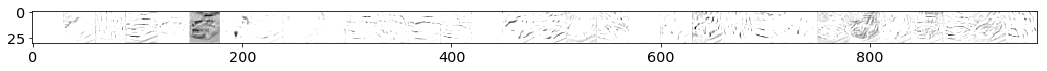

Displaying activation map 2


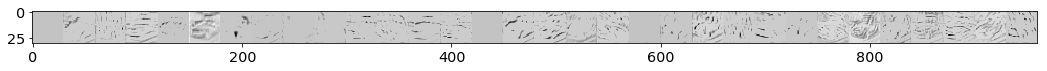

Displaying activation map 3


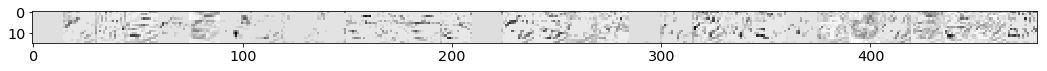

Displaying activation map 4


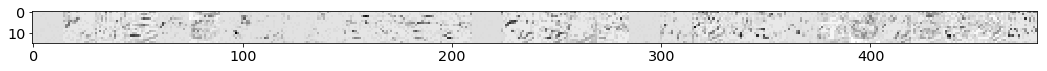

Displaying activation map 5


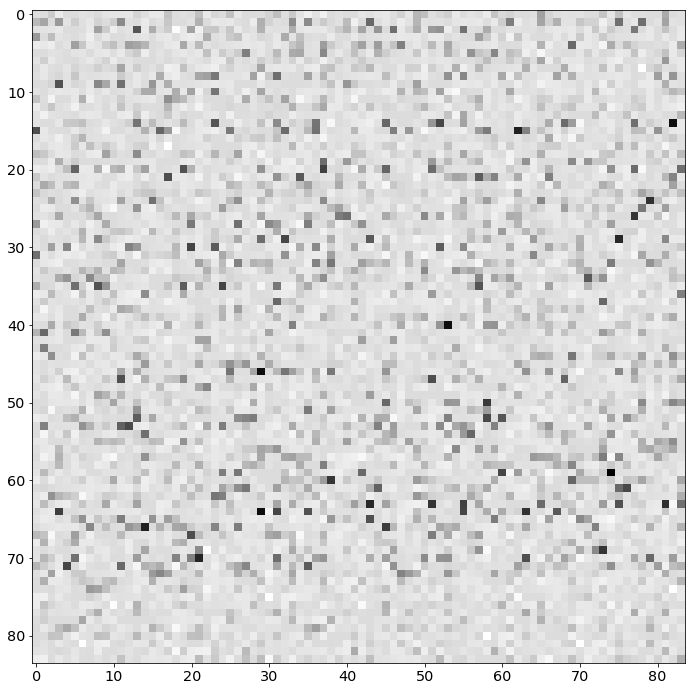

Displaying activation map 6


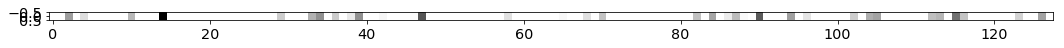

Displaying activation map 7


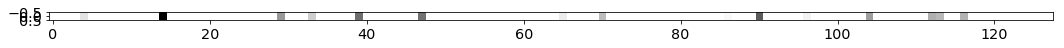

Displaying activation map 8


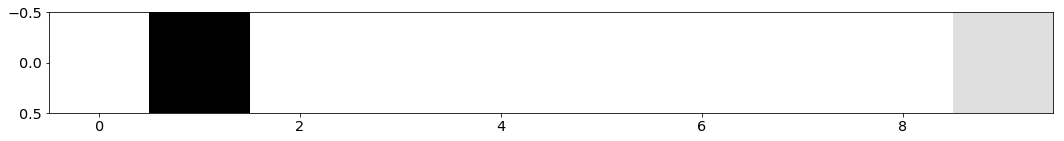

In [24]:
utils.display_activations(activations)

In [25]:
pred_label = label_dict.get(model.predict_classes(x_test[test_image_idx].reshape(1,32,32,3)).argmax())
actual_label = label_dict.get(y_test[test_image_idx].argmax())

1/1 [==============================] - 0s


In [26]:
print('Actual Label={}\nPredicted Label={}'.format(actual_label,pred_label))

Actual Label=automobile
Predicted Label=airplane
